In [1]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2

In [3]:
repo_path = "/local/lmseifert/Other/shaken_lattice_qoc/"
src_path = repo_path * "src/"
include(src_path * "utils.jl")
include(src_path * "system.jl")
include(src_path * "constraints.jl")
include(src_path * "objectives.jl")
include(src_path * "problems.jl")

SLProblemSetup (generic function with 1 method)

In [4]:
psi_odd = QC.cavity_state(3, 13)
psi_even = QC.cavity_state(4, 13)
psip = (psi_odd + psi_even)/sqrt(2)
psim = (-psi_odd + psi_even)/sqrt(2)

13-element Vector{ComplexF64}:
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
 -0.7071067811865475 + 0.0im
  0.7071067811865475 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im

In [24]:
system, Z_guess, J, integrators, constraints, options = SLProblemSetup(
    [psip, psi_even],
    [psim, psi_even],
    2pi*0.6;
    T=600,
    modulation=:phase
)

(QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096917395 4.855230060710805e-15 … -9.271503567352554e-8 -9.276310935107244e-8; 4.551570362061718e-15 -0.989957623122687 … -4.322997308940166e-7 4.320756953051173e-7; … ; -9.271503567352657e-8 -4.3229973089401554e-7 … 0.04371496864049468 1.0695767002499315e-16; -9.27631093510709e-8 4.320756953051205e-7 … 1.0695293321248293e-16 0.04371496864049443], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.

In [25]:
T = Z_guess.T
dim = system.params[:dim]
dts = Z_guess.dts
times = cumsum(dts[1,:]) .- dts[1]

600-element Vector{Float64}:
 0.0
 0.006293674765121456
 0.012587349530242913
 0.018881024295364368
 0.025174699060485823
 0.03146837382560728
 0.037762048590728736
 0.044055723355850195
 0.05034939812097165
 0.05664307288609311
 0.06293674765121457
 0.06923042241633602
 0.07552409718145747
 ⋮
 3.7006807618914124
 3.706974436656534
 3.7132681114216552
 3.7195617861867767
 3.725855460951898
 3.7321491357170196
 3.738442810482141
 3.7447364852472624
 3.751030160012384
 3.7573238347775053
 3.7636175095426267
 3.769911184307748

In [26]:
psi0t = hcat([QC.iso_to_ket(Z_guess.psi0_iso[:,t]) for t=1:T]...)
pops0t = abs2.(psi0t)

13×600 Matrix{Float64}:
 0.0  6.19222e-6   1.75887e-5   1.1326e-5    …  0.00229966   0.00233333
 0.0  7.15601e-5   0.000210372  0.000127006     0.0150096    0.0135858
 0.0  8.26656e-5   0.000245903  0.000143861     0.0102517    0.00951538
 0.5  0.499535     0.498982     0.499383        0.445838     0.446966
 0.5  0.500144     0.500071     0.500034        0.468088     0.469867
 0.0  8.03979e-5   0.000235976  0.000149853  …  0.0166628    0.0165139
 0.0  8.04945e-5   0.000236239  0.000149924     0.0145688    0.0143443
 0.0  1.40266e-7   4.93283e-7   3.35141e-7      0.013652     0.0134668
 0.0  1.40251e-7   4.93107e-7   3.35228e-7      0.0134768    0.0132771
 0.0  7.75892e-11  3.81372e-10  2.59601e-10     7.7407e-5    6.45721e-5
 0.0  5.25216e-11  2.58145e-10  1.75787e-10  …  5.27867e-5   4.41005e-5
 0.0  2.70509e-21  1.78153e-20  1.17082e-20     2.32214e-11  2.24254e-11
 0.0  2.94584e-14  2.14627e-13  1.48965e-13     2.29769e-5   2.21797e-5

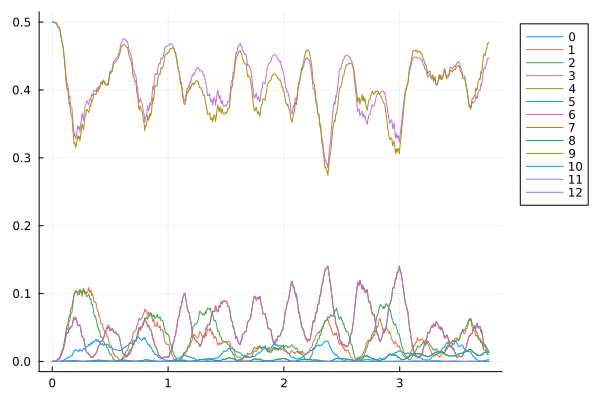

In [27]:
Plots.plot(times, pops0t[:,:]', labels=(0:dim-1)', legend=:outertopright)

In [28]:
J.L(Z_guess.datavec, Z_guess)

69.34747856151421

In [29]:
Z_guess.bounds

(dts = ([0.006293674765121456], [0.006293674765121456]), phi = ([-3.141592653589793], [3.141592653589793]))

In [30]:
kernel = sinc_kernel(50., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

600×600 Matrix{Float64}:
  0.854682     -0.137995     -0.126357     …  -0.00081533   -0.00109828
 -0.137995      0.864388     -0.128765        -0.000483745  -0.00081533
 -0.126357     -0.128765      0.873165        -0.000118998  -0.000467514
 -0.111118     -0.11789      -0.120714         0.000244381  -8.80766e-5
 -0.0931859    -0.103656     -0.110795         0.000572297   0.000286999
 -0.073603     -0.0869138    -0.0976922    …   0.000834351   0.000622458
 -0.0534697    -0.0686371    -0.0821919        0.00100674    0.000887147
 -0.033871     -0.0498549    -0.0652           0.00107448    0.00105698
 -0.0158042    -0.0315802    -0.0476767        0.00103281    0.00111722
 -0.000114473  -0.014743     -0.0305712        0.00088756    0.00106382
  0.0125551    -0.000130921  -0.0147587    …   0.000654531   0.000903746
  0.0217987     0.0116585    -0.000983512      0.000357872   0.000654251
  0.027463      0.0202493     0.0101852        2.76912e-5    0.000341098
  ⋮                             

In [31]:
Jconv = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:T; Q=50.0/T)
J2 = J + Jconv

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#L#21"{Vector{QuantumCollocation.Losses.InfidelityLoss}}(Core.Box((:psi0_iso,)), Core.Box(49.97859623209157), Core.Box([50.0]), QuantumCollocation.Losses.InfidelityLoss[QuantumCollocation.Losses.InfidelityLoss(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([0.0, 0.0, 0.0, -0.7071067811865475, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), QuantumCollocation.Losses.var"#23#26"{QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}}(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([0.0, 0.0, 0.0, -0.7071067811865475, 0.707106781186

In [32]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J2, 
    integrators;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi1_iso
applying constraint: initial value of phi
applying constraint: initial value of psi0_iso
applying constraint: final value of phi
applying constraint: bounds on dts
applying constraint: bounds on phi


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(57) … MOI.VariableIndex(33489) MOI.VariableIndex(33545); MOI.VariableIndex(2) MOI.VariableIndex(58) … MOI.VariableIndex(33490) MOI.VariableIndex(33546); … ; MOI.VariableIndex(55) MOI.VariableIndex(111) … MOI.VariableIndex(33543) MOI.VariableIndex(33599); MOI.VariableIndex(56) MOI.VariableIndex(112) … MOI.VariableIndex(33544) MOI.VariableIndex(33600)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096

In [33]:
QC.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:  1683036
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   242008

Total number of variables............................:    32946
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      598
                     variables with only upper bounds:        0
Total number of equality constraints.................:    32348
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4313605e+02 1.49e+00 4.40e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [34]:
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.711114329250242 … 0.027303717194521085 1.0; -1.0596828923602667e-23 -0.7030767184011489 … 0.9996276982872032 0.0; … ; 0.0 1.0303810162791204e-22 … 0.00128962750567824 0.000617641225707545; 0.0 8.673012962736391e-21 … 0.002011789317219356 -0.0007778246438764799], [1.0, -1.0596828923602667e-23, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0  …  0.20893393352140815, -0.1901255395275847, 0.0014811731850355454, -0.008554221576278933, 0.003986341926264297, -0.011422987616008752, 0.005779265760190481, 0.0004925229388014224, 0.000617641225707545, -0.0007778246438764799], 600, :dts, 56, (a = 2, psi1_iso = 26, dts = 1, phi = 1, psi0_iso = 26, states = 55, controls = 1), (dts = ([0.006293674765121456], [0.006293674765121456]), phi = ([-3.141592653589793], [3.141592653589793])), (psi1_iso = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0], psi0_iso = [0.0, 0.0, 0.0, 0

In [23]:
J.L(Z.datavec, Z)

0.02313845145721083

In [16]:
psi0t_iso = QC.rollout(Z.initial.psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi0t = hcat([QC.iso_to_ket(psi0t_iso[:,t]) for t=1:T]...)
pops0t = abs2.(psi0t)

13×700 Matrix{Float64}:
 0.0  2.89351e-34  4.26201e-9   …  2.97258e-5   6.50056e-6  1.30018e-6
 0.0  6.003e-33    4.68615e-8      0.000217032  3.158e-5    2.13319e-7
 0.0  7.11313e-33  5.35938e-8      0.000246513  3.80684e-5  4.00812e-8
 0.5  0.5          0.499992        0.499949     0.499979    0.499803
 0.5  0.5          0.500008        0.498876     0.499664    0.499984
 0.0  4.93938e-34  5.27157e-8   …  0.000333949  8.51038e-5  1.28132e-5
 0.0  5.19894e-34  5.28285e-8      0.000159752  8.38273e-6  1.03714e-5
 0.0  1.3731e-35   6.79415e-11     2.97422e-5   2.78196e-5  2.6677e-5
 0.0  1.02069e-35  6.79573e-11     3.40114e-5   3.63174e-5  3.86171e-5
 0.0  1.24787e-38  1.86419e-14     3.88041e-5   3.74364e-5  3.65763e-5
 0.0  1.19213e-38  1.26174e-14  …  5.62346e-6   5.57764e-6  5.47891e-6
 0.0  2.65559e-44  5.04512e-25     6.89851e-5   7.01535e-5  7.08791e-5
 0.0  1.8934e-40   2.31513e-18     1.08537e-5   1.06937e-5  1.05457e-5

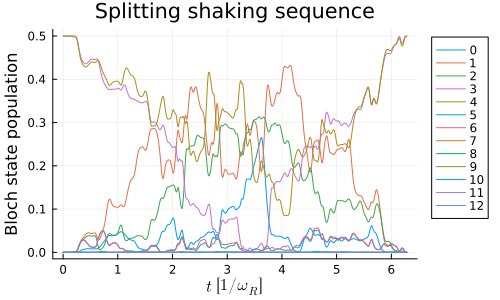

In [17]:
p = Plots.plot(times, pops0t[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

In [18]:
psi1t_iso = QC.rollout(Z.initial.psi1_iso, Z.a, Z.dts, system; integrator=exp)
psi1t = hcat([QC.iso_to_ket(psi1t_iso[:,t]) for t=1:T]...)
pops1t = abs2.(psi1t)

13×700 Matrix{Float64}:
 0.0  5.25646e-34  4.42325e-13  …  1.62603e-6   1.30091e-7  3.17293e-7
 0.0  1.14029e-33  9.37289e-8      0.000413565  6.56077e-5  1.59219e-7
 0.0  5.74809e-33  5.74501e-12     4.61258e-5   6.66541e-6  1.49008e-6
 0.0  4.85579e-30  7.0079e-11      5.45814e-7   1.77285e-7  4.93154e-8
 1.0  1.0          1.0             0.998809     0.999561    0.999674
 0.0  2.13143e-37  1.05429e-7   …  0.000367332  4.02342e-5  5.01354e-6
 0.0  1.01712e-33  5.56324e-12     5.16175e-5   1.35275e-5  6.54341e-6
 0.0  9.07382e-36  1.34648e-10     5.33608e-5   5.60863e-5  5.65073e-5
 0.0  6.12926e-36  9.76546e-15     5.45458e-5   5.5485e-5   5.50795e-5
 0.0  9.7962e-39   3.00523e-14     3.17286e-5   3.0412e-5   2.99613e-5
 0.0  6.09002e-39  1.949e-16    …  8.82906e-5   8.90615e-5  9.00928e-5
 0.0  8.29914e-46  9.79171e-19     6.50311e-5   6.45606e-5  6.39169e-5
 0.0  1.06068e-40  1.15736e-18     1.69102e-5   1.69302e-5  1.67912e-5

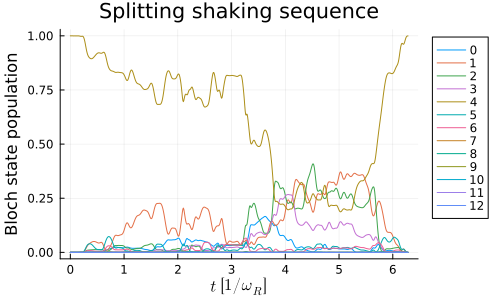

In [19]:
p = Plots.plot(times, pops1t[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

In [20]:
Plots.plot(times, pops[end,:])

LoadError: UndefVarError: `pops` not defined

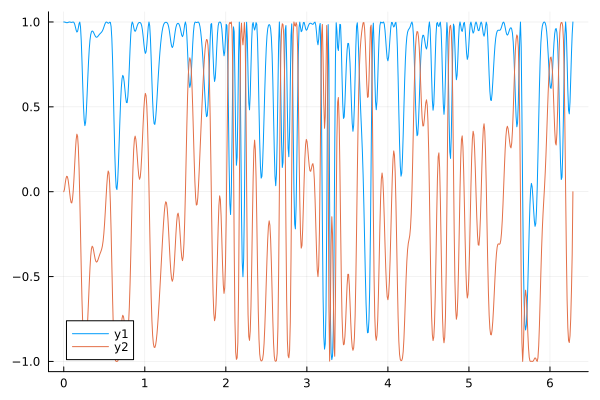

In [21]:
Plots.plot(times, Z.a')

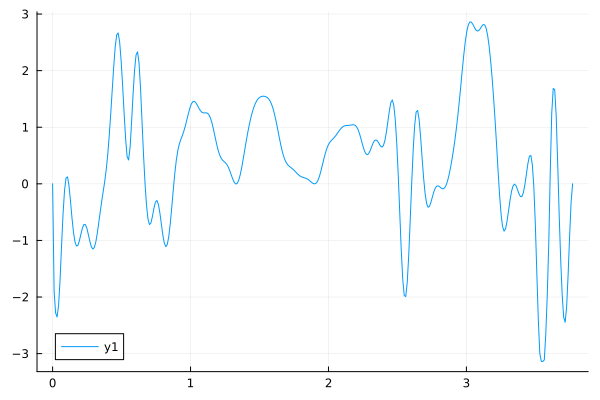

In [98]:
Plots.plot(times, Z.phi')

In [105]:
import JLD2

In [109]:
JLD2.save(repo_path * "interferometer/mirror_bloch34_$(round(times[end], digits=2))wr.jld2", Z)